In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
train_df = pd.read_csv('train.csv', encoding='windows-1252', low_memory=False)
test_df = pd.read_csv('test.csv')

train_df.head()
test_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,...,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [3]:
train_df.shape, test_df.shape

((250306, 34), (61001, 27))

<h2>Initial Cleaning</h2>
<br>
For the assignment, all violators that were found not responsible are not being considered in this evaluation.
    <ul>- Violators that are found not responsible will have NaN in compliance</ul>
<br>
Extra columns were also provided in training dataframe for reference but should not be considered in evaluation as well.

In [4]:
extra_cols = ['payment_amount','payment_date','payment_status','balance_due','collection_status','compliance_detail']
useless_cols = ['violation_street_name', 'mailing_address_str_name', 'country', 'violation_description',\
                'inspector_name', 'violator_name', 'grafitti_status', 'non_us_str_code']
train_df.drop(extra_cols, axis=1, inplace=True)
train_df.drop(useless_cols, axis=1, inplace=True)
train_df.dropna(subset=['compliance'], inplace=True)

In [5]:
# dropping useless columns in test dataframe as well
test_df.drop(useless_cols, axis=1, inplace=True)

<h3>Counting distribution of target</h3>

In [6]:
train_df['compliance'].value_counts()

0.0    148283
1.0     11597
Name: compliance, dtype: int64

<h3>Counting Nulls</h3>

In [7]:
train_df.isnull().sum().sort_values(ascending=False)

# a lot more of nulls in hearing dates were remove when removing target nulls

violation_zip_code            159880
mailing_address_str_number      2558
hearing_date                     227
state                             84
zip_code                           1
judgment_amount                    0
agency_name                        0
violation_street_number            0
city                               0
ticket_issued_date                 0
compliance                         0
violation_code                     0
disposition                        0
fine_amount                        0
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
ticket_id                          0
dtype: int64

<h3>Column Types</h3>

In [8]:
train_df.dtypes.value_counts()

float64    11
object      8
int64       1
dtype: int64

<h3>Counts of unique values for categorical columns</h3>

In [9]:
train_df.select_dtypes('object').apply(pd.Series.nunique, axis=0).sort_values(ascending=False)

ticket_issued_date    68097
hearing_date           5970
city                   4093
zip_code               3498
violation_code          189
state                    59
agency_name               5
disposition               4
dtype: int64

<h3>Dealing with dates</h3>
<br>Date part the datetime columns</br>
<br>Get difference between ticket_issued_date & hearing_date (use this for transformation)</br>

In [10]:
from datetime import datetime

#train data
train_df['hearing_issue_date_diff'] = (train_df['hearing_date'].astype('datetime64') -\
                                    train_df['ticket_issued_date'].astype('datetime64')).dt.days
train_df = train_df[train_df['hearing_issue_date_diff'] >= 0]

#test data
test_df['hearing_issue_date_diff'] = (test_df['hearing_date'].astype('datetime64') -\
                                    test_df['ticket_issued_date'].astype('datetime64')).dt.days
test_df = test_df[test_df['hearing_issue_date_diff'] >= 0]
#train_df['hearing_issue_date_diff'].head()

<h3>Dropping location columns for the sake of simplicity.
Dropping violation_code for now and get baseline results. May add it back into columns if needed.</h3>

For violation_code maybe only include violations with occurances above the mean of count

In [11]:
train_df.drop(['ticket_issued_date','hearing_date','city','zip_code','violation_code','state'], axis=1, inplace=True)
test_df.drop(['ticket_issued_date','hearing_date','city','zip_code','violation_code','state'], axis=1, inplace=True)

<h3>Dropping remaining location columns. Added benefit of removing columns with high number of null values to simplify further</h3>

In [12]:
train_df.drop(['violation_zip_code', 'mailing_address_str_number'], axis=1, inplace=True)
test_df.drop(['violation_zip_code', 'mailing_address_str_number'], axis=1, inplace=True)

train_df.shape, test_df.shape

((159573, 13), (58695, 12))

<h3>Note: Categorical variables in 'agency_name' and 'disposition' columns in train and test data do not align</h3>

In [13]:
print(train_df.select_dtypes('object').apply(pd.Series.nunique, axis=0).sort_values(ascending=False))
print(test_df.select_dtypes('object').apply(pd.Series.nunique, axis=0).sort_values(ascending=False))

agency_name    5
disposition    4
dtype: int64
disposition    8
agency_name    3
dtype: int64


In [14]:
train_df = pd.get_dummies(train_df)
test_df = pd.get_dummies(test_df)

<h3>Aligning training and testing data</h3>

In [15]:
train_labels = train_df['compliance']

train_df, test_df = train_df.align(test_df, join='inner', axis=1)
train_df['compliance'] = train_labels

train_df.shape, test_df.shape

((159573, 18), (58695, 17))

<h3>Reviewing Anomalies</h3>

In [16]:
train_df.describe()

,ticket_id,violation_street_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,hearing_issue_date_diff,"agency_name_Buildings, Safety Engineering & Env Department",agency_name_Department of Public Works,agency_name_Detroit Police Department,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,compliance
count,159573.000000,1.595730e+05,159573.000000,159573.0,159573.0,159573.000000,159573.000000,159573.0,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000,159573.000000
mean,150410.866914,1.071450e+04,356.856755,20.0,10.0,33.664742,0.167384,0.0,420.486152,72.749387,0.600008,0.327555,0.027950,0.001178,0.085578,0.865848,0.047395,0.071585
std,77211.873052,3.626543e+04,675.672888,0.0,0.0,67.704086,3.960415,0.0,742.605232,62.451159,0.489898,0.469323,0.164829,0.034304,0.279741,0.340816,0.212483,0.257800
min,18645.000000,0.000000e+00,0.000000,20.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,83332.000000,4.920000e+03,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,149731.000000,1.039900e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,54.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,217403.000000,1.578500e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,100.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,299363.000000,1.415411e+07,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,7933.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
train_df.corr()['compliance'].sort_values()

disposition_Responsible by Default                           -0.333485
late_fee                                                     -0.084197
agency_name_Buildings, Safety Engineering & Env Department   -0.053683
judgment_amount                                              -0.052883
fine_amount                                                  -0.049497
ticket_id                                                    -0.026394
hearing_issue_date_diff                                      -0.004450
violation_street_number                                      -0.002444
agency_name_Detroit Police Department                         0.039042
agency_name_Department of Public Works                        0.044820
disposition_Responsible (Fine Waived) by Deter                0.123685
discount_amount                                               0.144290
disposition_Responsible by Determination                      0.199587
disposition_Responsible by Admission                          0.239526
compli

<h4>admin_fee, state_fee, clean_up_cost all have same values</h4>

<h3>Checking the highest correlated column</h3>

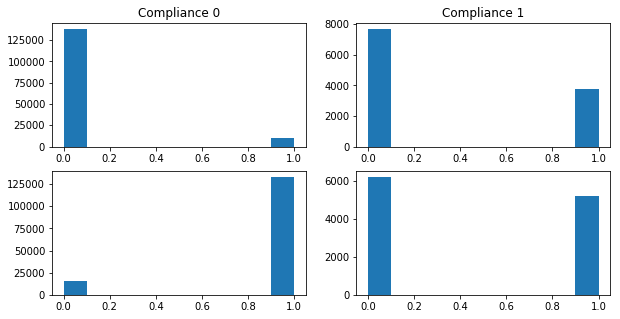

In [18]:
fig, ax = plt.subplots(2,2, figsize=(10,5))

ax[0,0].hist(train_df.loc[train_df['compliance'] == 0, 'disposition_Responsible by Admission'])
ax[0,1].hist(train_df.loc[train_df['compliance'] == 1, 'disposition_Responsible by Admission'])

ax[1,0].hist(train_df.loc[train_df['compliance'] == 0, 'disposition_Responsible by Default'])
ax[1,1].hist(train_df.loc[train_df['compliance'] == 1, 'disposition_Responsible by Default'])

ax[0,0].title.set_text('Compliance 0')
ax[0,1].title.set_text('Compliance 1')

In [22]:
train_ticket_id, test_ticket_id = train_df[['ticket_id']], test_df[['ticket_id']]

y_train = train_df.copy()['compliance']
X_train = train_df.copy().drop(columns=['ticket_id','compliance'])
X_test = test_df.copy().drop(columns=['ticket_id'])

features = list(X_train.columns)

<h3>Trying Logistic Regression as baseline performance</h3>
<br>Starting without any scaling or preprocessing</br>

In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

predict = lr.predict_proba(X_test)[:,1]
predict

array([0.05938928, 0.02090045, 0.05876388, ..., 0.0563989 , 0.05638769,
       0.07975519])

In [29]:
results = test_ticket_id.iloc[:,:]
results['target'] = predict

results.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ticket_id,target
0,284932,0.059389
1,285362,0.020900
2,285361,0.058764
3,285338,0.064504
4,285346,0.071685


In [30]:
# notes/things to do

# target length should be 61001
# check where rows were removed from x_test

# how to get ruc score without true y_test